# llc4320 drifters spectra: Lagrangian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6288085.datarmor0/parcels-502027/libparcels_random_2c5b4473-ad99-4bc4-9d4b-b8f9d46e1d3c.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    #w = cluster.scale(jobs=15)
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.123:60783 Dashboard: http://10.148.0.123:8787/status,Cluster Workers: 21 Cores: 21 Memory: 335.37 GiB


---
# Lagrangian spectra
### last update: 2023.08.08

In [3]:
D = '/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics'

In [5]:
# load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

---
## 1. lat x lon binning spectra (i.e. 2D spectra) 

## This is done by AP 

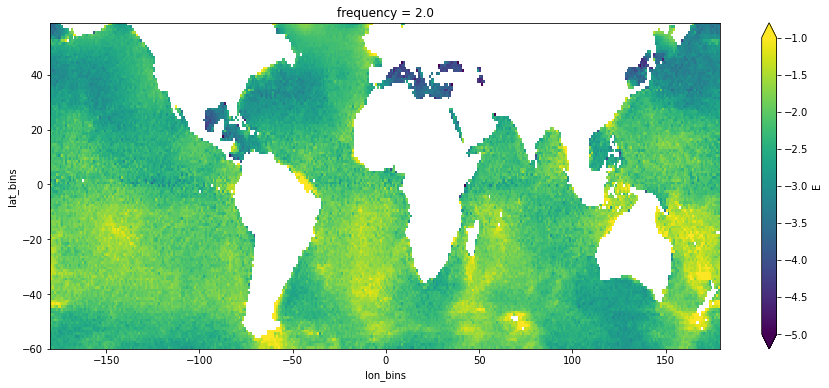

In [6]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean0_lon_lat.zarr')
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E.sel(frequency=2)).plot(x='lon_bins',cmap='viridis', vmin=-5, vmax=-1)

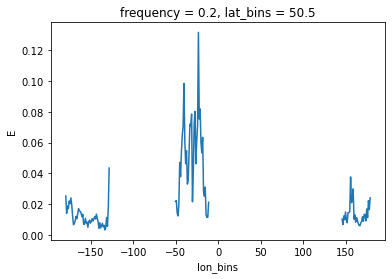

In [7]:
ds = p.load_diagnostic('spectra_uv_T60_mean0_lon_lat.zarr')
ds.E.sel(frequency=.2).isel(lat_bins=110).plot()

__________________
## 2. Zonally averaged spectra (i.e.,1D, as a function of lat) 
### method 2: from 2D binned Lagrangian spectra (i.e. from section 1)

In [4]:
#root_dir = '/home1/datawork/aponte/parcels/'
root_dir = os.path.join(ut.root_data_dir, 'parcels')

run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(os.path.join(root_dir, run_name), 
                      parquets=['trajectory'],
                     )


In [10]:
V = ["mean0", "mean1", "mean2"]

for v in V:

    ds = p.load_diagnostic('spectra_uv_T60_%s_lon_lat.zarr'%(v))
    E = ds.mean('lon_bins')    
    p.store_diagnostic('spectra_uv_T60_%s_lat_from_2Dbinned_spectra'%(v), E, overwrite=True)
    print('<%s - allready processed>'%(v))        

spectra_uv_T60_mean0_lat_from_2Dbinned_spectra diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat_from_2Dbinned_spectra.zarr
<mean0 - allready processed>
spectra_uv_T60_mean1_lat_from_2Dbinned_spectra diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat_from_2Dbinned_spectra.zarr
<mean1 - allready processed>
spectra_uv_T60_mean2_lat_from_2Dbinned_spectra diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat_from_2Dbinned_spectra.zarr
<mean2 - allready processed>


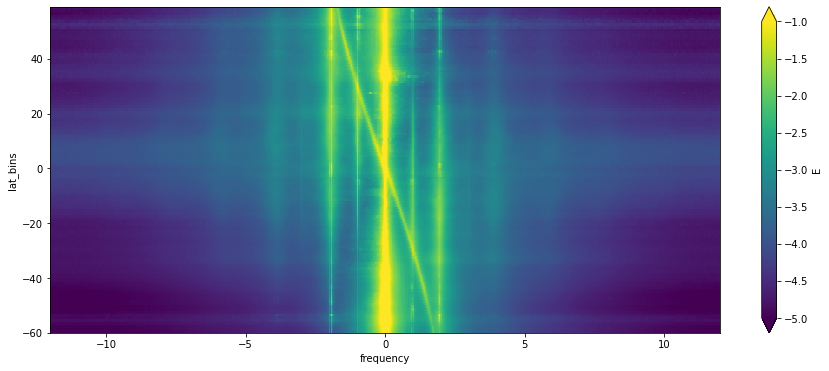

In [11]:
# load
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_from_2Dbinned_spectra.zarr')

fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

(-3.0, 3.0)

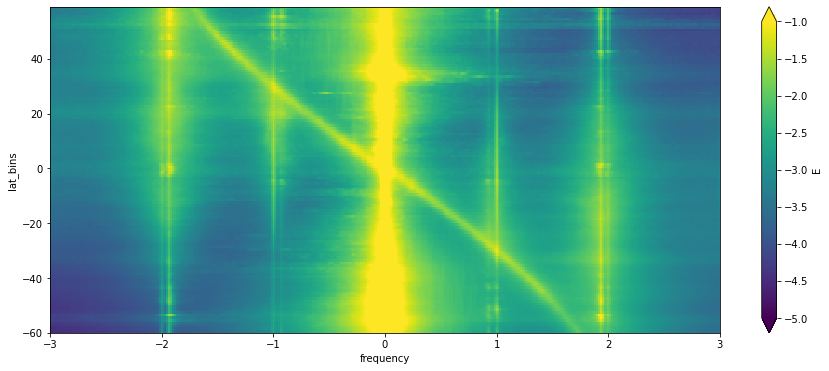

In [13]:
# load
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_from_2Dbinned_spectra.zarr')

fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

ax.set_xlim(-3., 3.)

_____________
# 3. Lagrangian KE maps

## lon x lat for band-integrated KE

In [14]:
V = ["mean0","mean1","mean2"]

for v in V:
    
    ds = p.load_diagnostic('spectra_uv_T60_%s_lon_lat.zarr'%(v))

    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds.lat_bins))
    f_cpd_llc = f_llc*86400/2./np.pi

    bands = {'total': (0., 12), 'low': (0., .5), 'supertidal': (2.4, 12),
             'diurnal_0dot1': (0.9, 1.1), 'diurnal_0dot2': (0.8, 1.2), 'diurnal_0dot3': (0.7, 1.3), 'diurnal_0dot4': (0.6, 1.4),
             'semidiurnal_0dot1': (1.9, 2.1), 'semidiurnal_0dot2': (1.8, 2.2), 'semidiurnal_0dot3': (1.7, 2.3), 'semidiurnal_0dot4': (1.6, 2.4),
             'inertial_0dot1':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),'inertial_0dot2':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),
             'inertial_0dot3':(f_cpd_llc.values.min(),f_cpd_llc.values.max()),'inertial_0dot4':(f_cpd_llc.values.min(),f_cpd_llc.values.max())
            }
    
    domega = float(ds.frequency[1]- ds.frequency[0])

    Eb = {}
    for b, bounds in bands.items():
        #print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

        if b == "inertial_0dot1":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.1), 
                        drop=False,
                       )
        elif b == "inertial_0dot2":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.2), 
                        drop=False,
                       )
        elif b == "inertial_0dot3":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.3), 
                        drop=False,
                       )
        elif b == "inertial_0dot4":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.4), 
                        drop=False,
                       )            
            
        else:
            _E = ds.E.where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                            drop=False,
                           )

        E = domega * _E.sum('frequency')    
        Eb[b] = E.persist()

    # converts to single dataset and store:
    E = xr.concat(list(Eb.values()), 
                  dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                 )
    
    E = E.where(E>0)
    # store diagnostic
    p.store_diagnostic('spectra_uv_T60_%s_lat_lon_bands'%(v), E.to_dataset(), overwrite=True)

spectra_uv_T60_mean0_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat_lon_bands.zarr
spectra_uv_T60_mean1_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat_lon_bands.zarr
spectra_uv_T60_mean2_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat_lon_bands.zarr


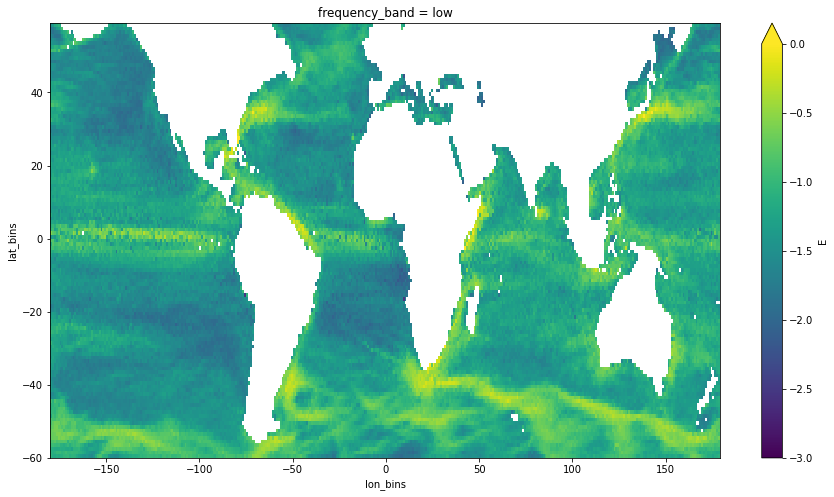

In [18]:
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

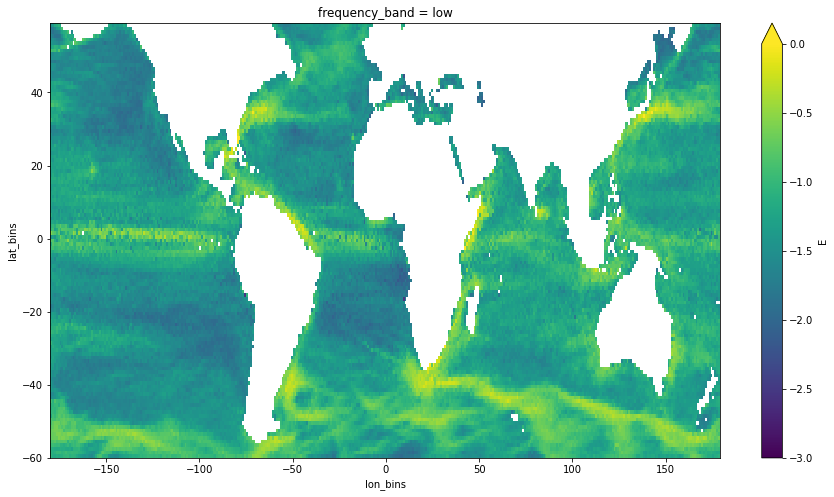

In [13]:
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

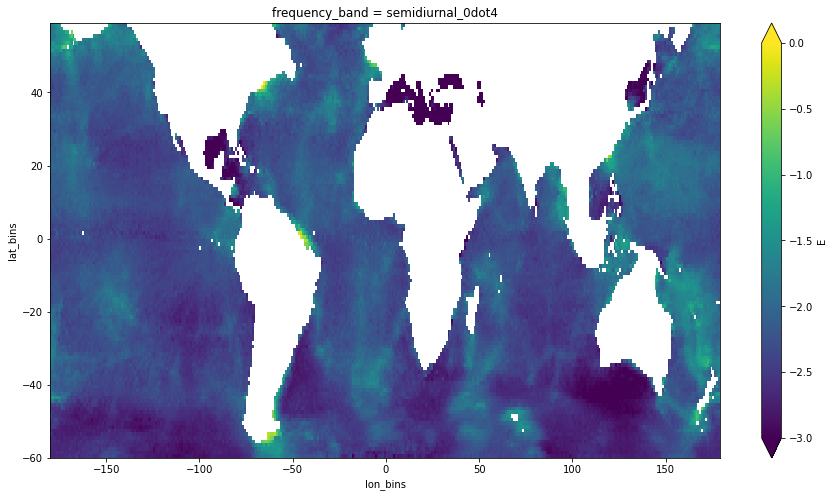

In [16]:
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='semidiurnal_0dot4').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

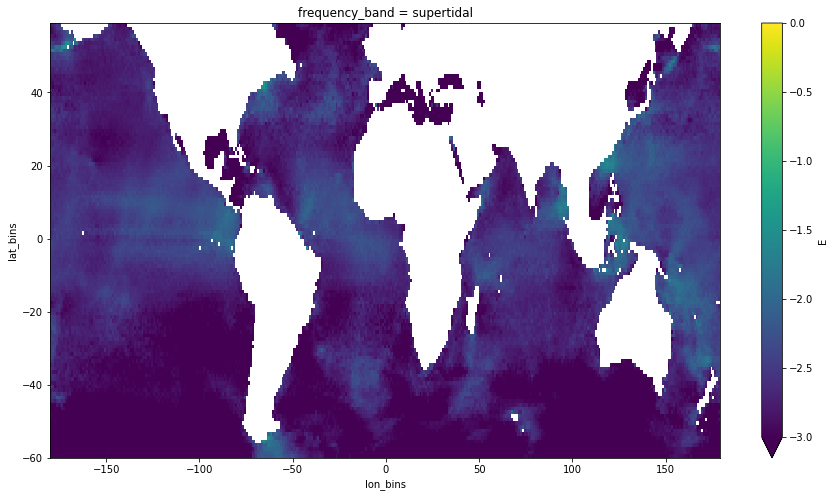

In [15]:
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='supertidal').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

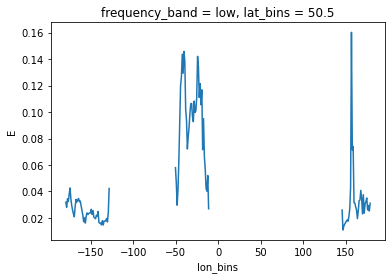

In [14]:
ds.E.sel(frequency_band='low').isel(lat_bins=110).plot()

## Close cluster

In [19]:
cluster.close()